In [1]:
# import the necessary packages
import numpy as np
import cv2
from matplotlib import pyplot as plt
import imutils

In [2]:
from os import listdir
from os.path import isfile, join
images_paths = sorted([f for f in listdir('../images') if isfile(join('../images', f))])

In [64]:
def bound_box(image_path):
    # load the image and convert it to grayscale
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    """print(image.shape)
    plt.imshow(gray, 'gray')"""

    # compute the Scharr gradient magnitude representation of the images
    # in both the x and y direction using OpenCV 2.4
    ddepth = cv2.cv.CV_32F if imutils.is_cv2() else cv2.CV_32F
    gradX = cv2.Sobel(gray, ddepth=ddepth, dx=1, dy=0, ksize=-1)
    gradY = cv2.Sobel(gray, ddepth=ddepth, dx=0, dy=1, ksize=-1)
    # subtract the y-gradient from the x-gradient
    gradient = cv2.subtract(gradX, gradY)
    gradient = cv2.convertScaleAbs(gradient)

    #image_derivative = np.maximum(image_horizontal_derivative, image_vertical_derivative)

    """plt.figure()
    plt.imshow(image_horizontal_derivative, 'gray')"""
    
    blurred = cv2.blur(gradient, (9, 9))
    ret2,thresh = cv2.threshold(blurred,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    
    #kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (20, 20))
    #closed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
    
    #kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 100))
    #opened = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
    
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (30, 7))
    closed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
    
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (50, 50))
    opened = cv2.morphologyEx(closed, cv2.MORPH_OPEN, kernel)
    
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (10, 1))
    dilated = cv2.dilate(opened, kernel, iterations=3)
    
    cnts = cv2.findContours(dilated.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    #print(cnts)
    cnts = imutils.grab_contours(cnts)
    c = sorted(cnts, key = cv2.contourArea, reverse = True)[0]
    # compute the rotated bounding box of the largest contour
    rect = cv2.minAreaRect(c)
    #print(rect)
    box = cv2.cv.BoxPoints(rect) if imutils.is_cv2() else cv2.boxPoints(rect)
    box = np.int0(box)
    #print(box)
    # draw a bounding box arounded the detected barcode and display the
    # image
    image_bb = image.copy()
    cv2.drawContours(image_bb, [box], -1, (0, 255, 0), 3)
    plt.figure()
    plt.imshow(image_bb, 'gray')
    
    coordinates_source = box.astype('float32')
    min_width = coordinates_source[:,0].min()
    min_height = coordinates_source[:,1].min()
    max_width = coordinates_source[:,0].max()
    max_height = coordinates_source[:,1].max()
    def normalize(value, axis=0):
        if axis==0:  # Horizontal dimension
            return min_width if (value-min_width<max_width-value) \
                             else max_width
        elif axis==1:  # Vertical dimension
            return min_height if (value-min_height<max_height-value) \
                              else max_height
    coordinates_source = np.array(sorted([tuple(v) for v in coordinates_source], key=lambda t: (normalize(t[1], axis=1),
                                                                                                normalize(t[0], axis=0))))
    print(coordinates_source)
    def dist(point1, point2):
        return np.sqrt(np.sum((point1-point2)**2))
    destination_height = int(max([dist(coordinates_source[0],coordinates_source[2]),
                             dist(coordinates_source[1],coordinates_source[3])]))
    destination_width = int(max([dist(coordinates_source[0],coordinates_source[1]),
                             dist(coordinates_source[2],coordinates_source[3])]))
    coordinates_destination = np.array([[0, 0],
                                        [destination_width-1, 0],
                                        [0, destination_height-1],
                                        [destination_width-1, destination_height-1]], dtype='float32')
    # Computing the trasformation, i.e. homography. Warping.
    H = cv2.getPerspectiveTransform(coordinates_source, coordinates_destination)
    # Applying the trasformation
    gray1 = cv2.warpPerspective(gray, H, (destination_width, destination_height))
    plt.figure()
    plt.imshow(gray1, 'gray')

[[ 397.  254.]
 [1294.  250.]
 [ 401. 1059.]
 [1298. 1055.]]
Wall time: 105 ms


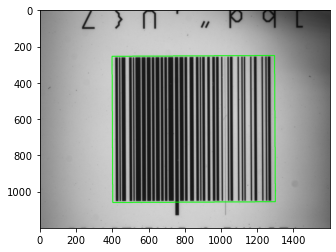

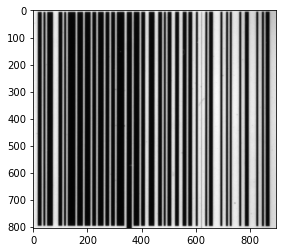

In [4]:
%%time
bound_box(f'../images/{images_paths[0]}')

[[ 345.  281.]
 [1245.  282.]
 [ 345. 1089.]
 [1245. 1089.]]
Wall time: 91 ms


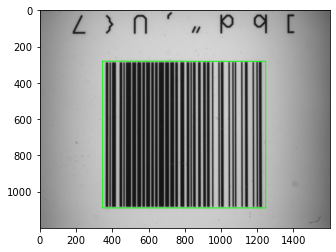

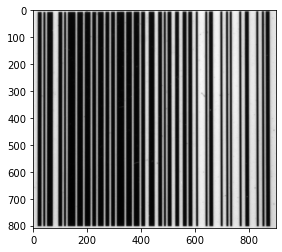

In [5]:
%%time
bound_box(f'../images/{images_paths[1]}')

[[ 197.  236.]
 [1040.  231.]
 [ 200.  729.]
 [1043.  724.]]
Wall time: 87.1 ms


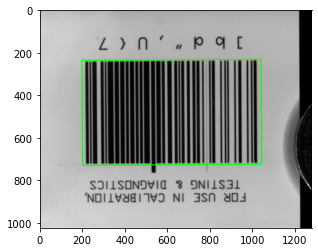

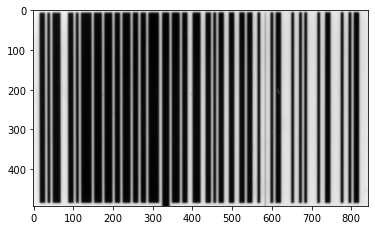

In [6]:
%%time
bound_box(f'../images/{images_paths[2]}')

[[128. 252.]
 [971. 252.]
 [128. 745.]
 [971. 745.]]
Wall time: 81.2 ms


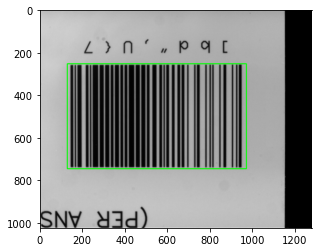

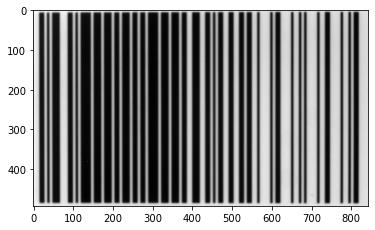

In [7]:
%%time
bound_box(f'../images/{images_paths[3]}')

[[333. 166.]
 [903. 166.]
 [333. 690.]
 [903. 690.]]
Wall time: 75 ms


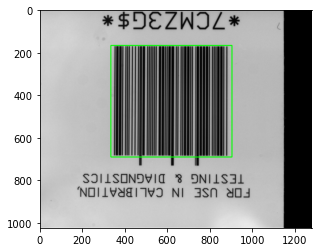

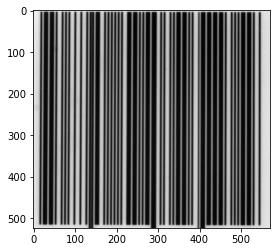

In [8]:
%%time
bound_box(f'../images/{images_paths[4]}')

[[340. 245.]
 [912. 245.]
 [340. 769.]
 [912. 769.]]


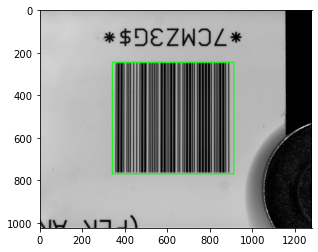

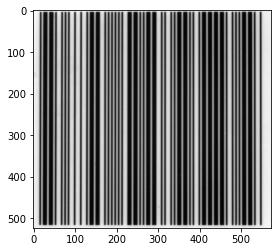

In [9]:
bound_box(f'../images/{images_paths[5]}')

[[ 160.  282.]
 [1101.  279.]
 [ 162.  806.]
 [1102.  803.]]


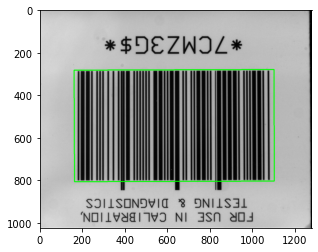

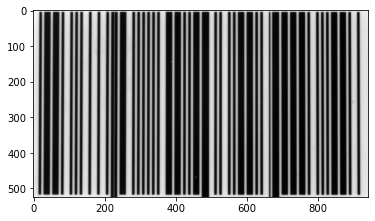

In [10]:
bound_box(f'../images/{images_paths[6]}')

[[ 148.  270.]
 [1092.  270.]
 [ 148.  794.]
 [1092.  794.]]


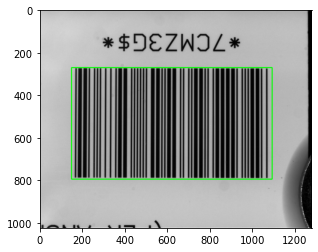

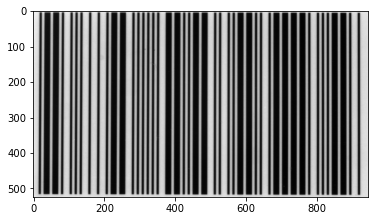

In [11]:
bound_box(f'../images/{images_paths[7]}')

[[ 148.  270.]
 [1092.  270.]
 [ 148.  794.]
 [1092.  794.]]


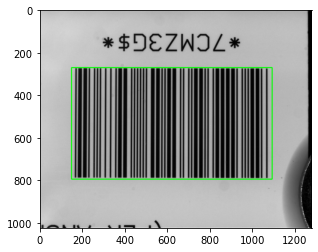

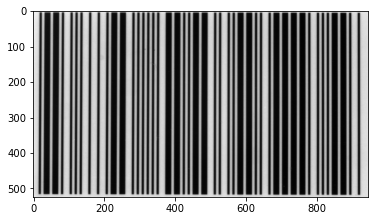

In [12]:
bound_box(f'../images/{images_paths[7]}')

[[328. 331.]
 [973. 335.]
 [326. 783.]
 [970. 787.]]


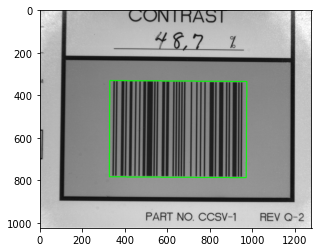

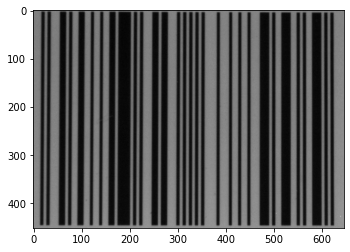

In [13]:
bound_box(f'../images/{images_paths[8]}')

[[341. 249.]
 [980. 258.]
 [335. 723.]
 [974. 732.]]


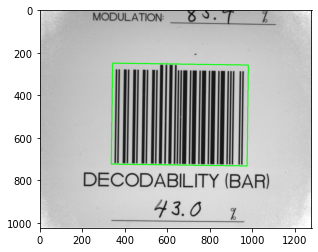

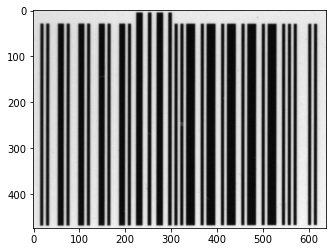

In [14]:
bound_box(f'../images/{images_paths[9]}')

In [15]:
print(f'../images/{images_paths[10]}')

images/EAN-UPC-DEFECTS IMGB.BMP


In [16]:
#bound_box(f'../images/{images_paths[10]}')

[[270. 259.]
 [955. 256.]
 [272. 760.]
 [957. 757.]]


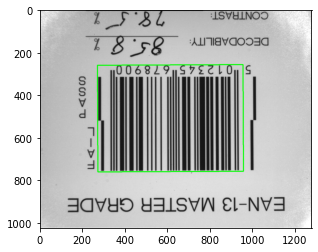

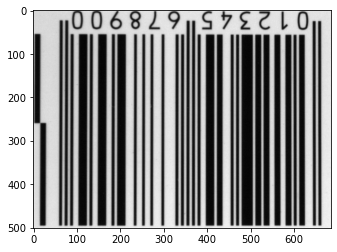

In [17]:
bound_box(f'../images/{images_paths[11]}')

In [18]:
#bound_box(f'../images/{images_paths[12]}')

[[  97.  113.]
 [1295.  115.]
 [  96.  314.]
 [1294.  316.]]


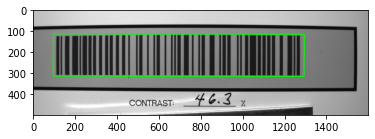

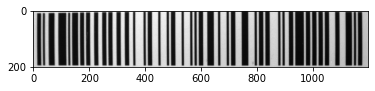

In [19]:
bound_box(f'../images/{images_paths[13]}')

[[ 160.  140.]
 [1352.  140.]
 [ 160.  340.]
 [1352.  340.]]


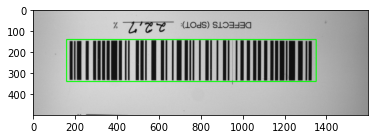

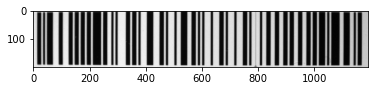

In [20]:
bound_box(f'../images/{images_paths[14]}')

[[ 174.  161.]
 [1385.  149.]
 [ 176.  365.]
 [1387.  353.]]


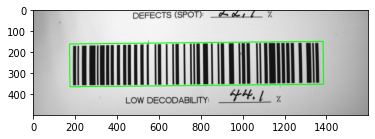

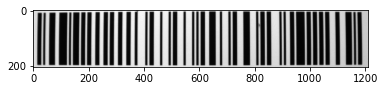

In [21]:
bound_box(f'../images/{images_paths[15]}')

[[ 198.  136.]
 [1392.  136.]
 [ 198.  336.]
 [1392.  336.]]


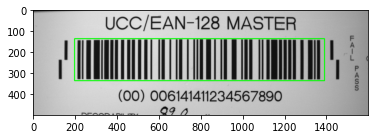

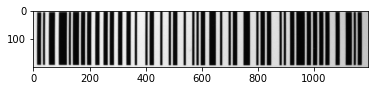

In [22]:
bound_box(f'../images/{images_paths[16]}')

[[ 194.  139.]
 [1352.  120.]
 [ 198.  389.]
 [1356.  370.]]


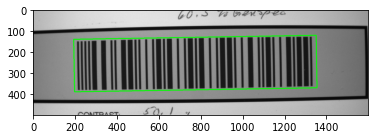

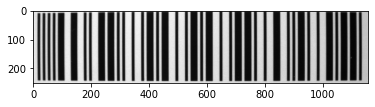

In [23]:
bound_box(f'../images/{images_paths[17]}')

[[ 196.  124.]
 [1358.  113.]
 [ 198.  375.]
 [1360.  363.]]


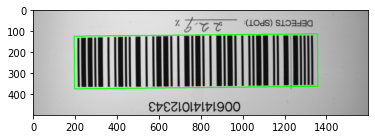

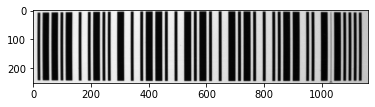

In [24]:
bound_box(f'../images/{images_paths[18]}')

[[ 229.   54.]
 [1387.   54.]
 [ 229.  303.]
 [1387.  303.]]


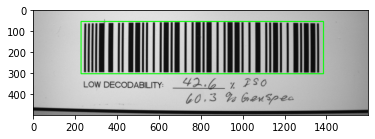

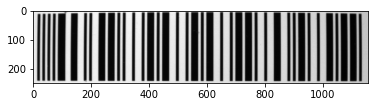

In [25]:
bound_box(f'../images/{images_paths[19]}')

[[ 246.  137.]
 [1408.  124.]
 [ 249.  387.]
 [1411.  374.]]


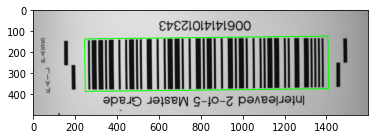

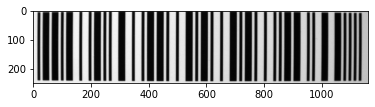

In [26]:
bound_box(f'../images/{images_paths[20]}')

In [27]:
print(f'../images/{images_paths[21]}')

images/TestChart.xls


In [28]:
#bound_box(f'../images/{images_paths[21]}')

[[240. 185.]
 [825. 181.]
 [243. 646.]
 [829. 641.]]


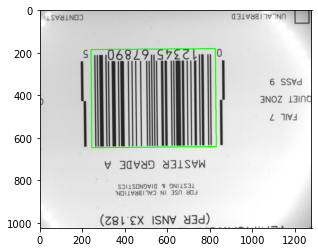

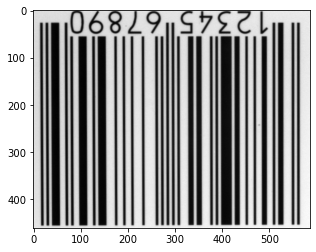

In [29]:
bound_box(f'../images/{images_paths[22]}')

[[240. 185.]
 [825. 181.]
 [243. 646.]
 [829. 641.]]


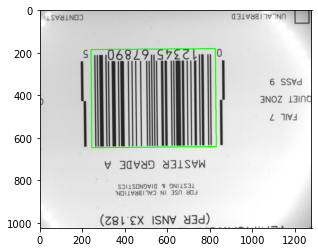

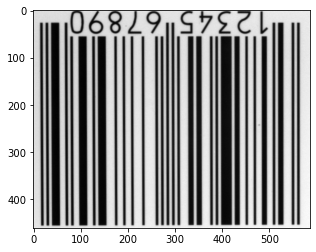

In [30]:
bound_box(f'../images/{images_paths[22]}')

[[312. 279.]
 [898. 285.]
 [308. 739.]
 [893. 744.]]


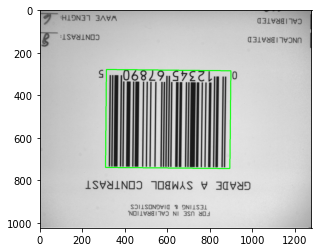

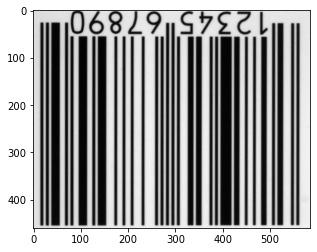

In [31]:
bound_box(f'../images/{images_paths[23]}')

[[346. 275.]
 [929. 285.]
 [339. 734.]
 [921. 744.]]


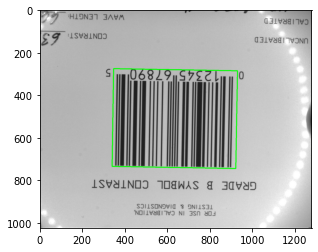

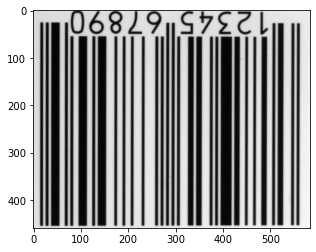

In [32]:
bound_box(f'../images/{images_paths[24]}')

[[354. 279.]
 [937. 281.]
 [351. 737.]
 [935. 740.]]


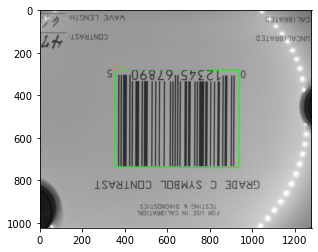

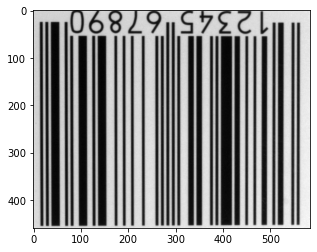

In [33]:
bound_box(f'../images/{images_paths[25]}')

[[294. 253.]
 [876. 273.]
 [279. 714.]
 [861. 734.]]


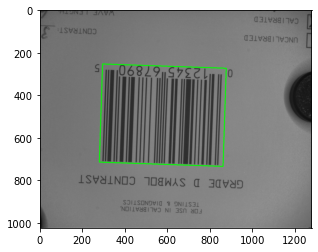

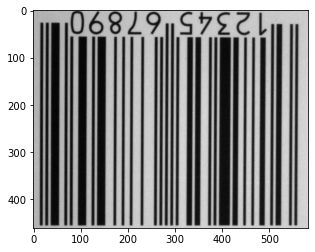

In [34]:
bound_box(f'../images/{images_paths[26]}')

[[330. 281.]
 [912. 290.]
 [323. 724.]
 [905. 734.]]


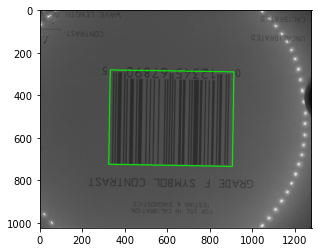

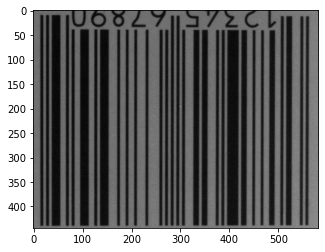

In [35]:
bound_box(f'../images/{images_paths[27]}')

[[324. 267.]
 [909. 273.]
 [319. 730.]
 [904. 737.]]


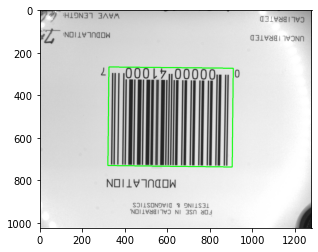

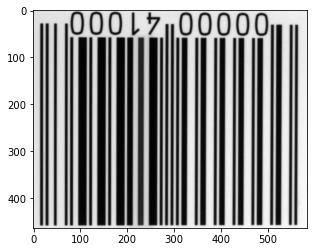

In [36]:
bound_box(f'../images/{images_paths[28]}')

[[324. 272.]
 [909. 282.]
 [316. 735.]
 [901. 746.]]


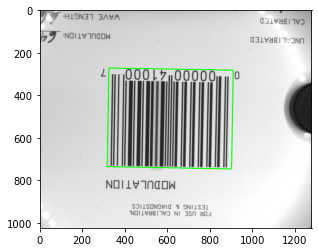

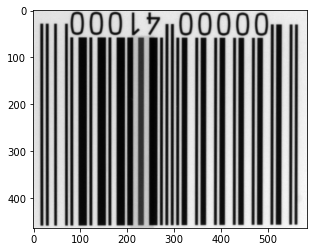

In [37]:
bound_box(f'../images/{images_paths[29]}')

[[321. 283.]
 [906. 293.]
 [313. 746.]
 [898. 756.]]


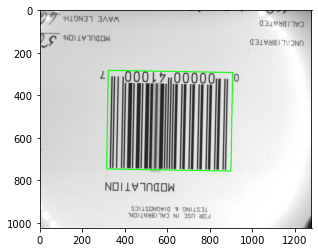

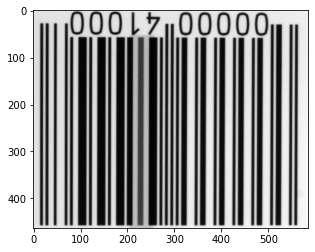

In [38]:
bound_box(f'../images/{images_paths[30]}')

[[330. 271.]
 [913. 288.]
 [317. 734.]
 [900. 751.]]


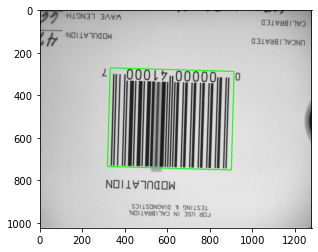

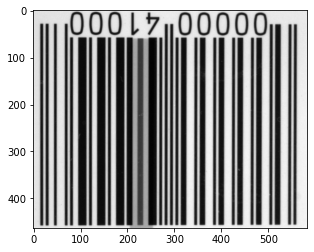

In [39]:
bound_box(f'../images/{images_paths[31]}')

[[330. 264.]
 [914. 264.]
 [330. 726.]
 [914. 726.]]


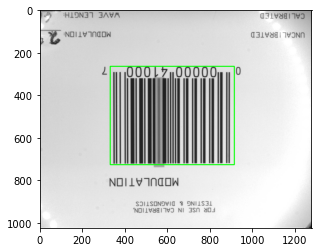

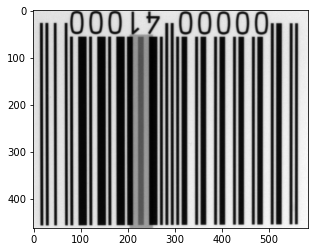

In [40]:
bound_box(f'../images/{images_paths[32]}')

[[342. 270.]
 [926. 276.]
 [338. 732.]
 [922. 738.]]


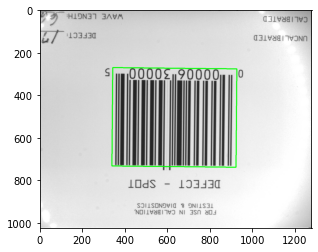

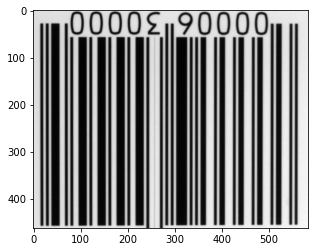

In [41]:
bound_box(f'../images/{images_paths[34]}')

[[342. 261.]
 [926. 268.]
 [336. 723.]
 [920. 730.]]


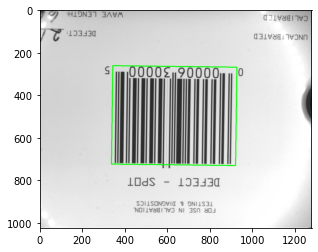

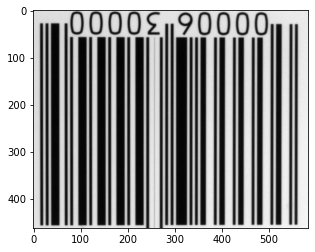

In [42]:
bound_box(f'../images/{images_paths[35]}')

[[329. 264.]
 [913. 264.]
 [329. 726.]
 [913. 726.]]


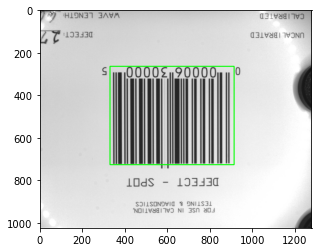

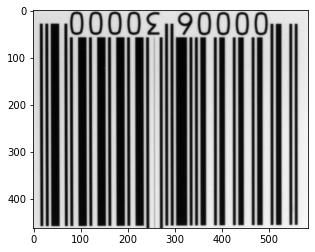

In [43]:
bound_box(f'../images/{images_paths[36]}')

[[317. 271.]
 [900. 271.]
 [317. 733.]
 [900. 733.]]


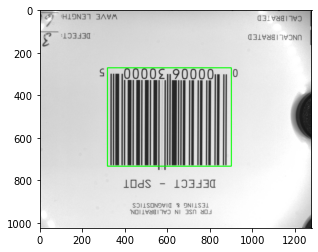

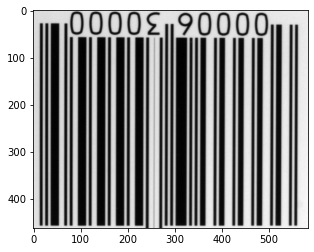

In [44]:
bound_box(f'../images/{images_paths[37]}')

[[327. 272.]
 [912. 273.]
 [327. 734.]
 [912. 734.]]


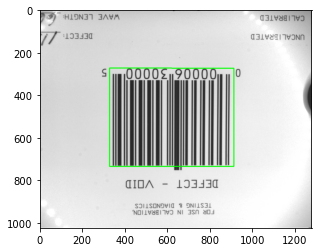

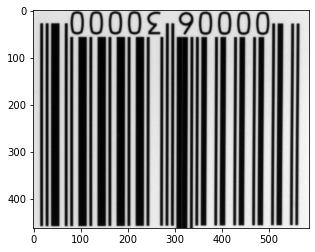

In [45]:
bound_box(f'../images/{images_paths[38]}')

[[332. 264.]
 [917. 269.]
 [328. 727.]
 [912. 732.]]


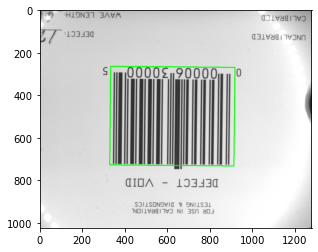

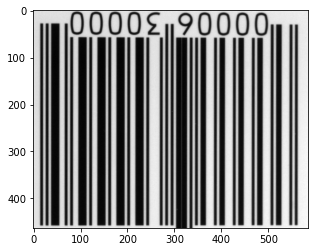

In [46]:
bound_box(f'../images/{images_paths[39]}')

[[296. 274.]
 [881. 276.]
 [294. 736.]
 [879. 739.]]


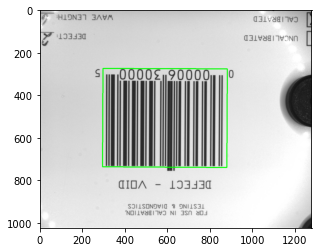

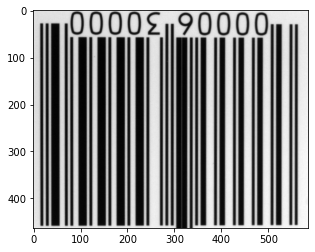

In [47]:
bound_box(f'../images/{images_paths[40]}')

[[252. 273.]
 [930. 279.]
 [248. 756.]
 [926. 761.]]


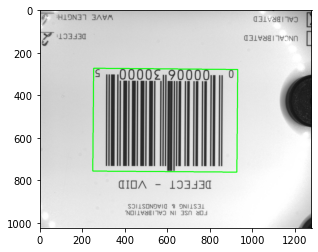

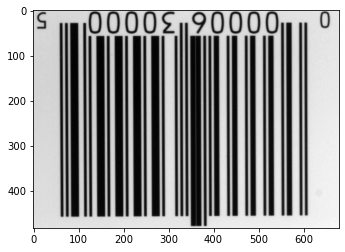

In [65]:
bound_box(f'../images/{images_paths[40]}')

[[285. 267.]
 [870. 264.]
 [287. 729.]
 [872. 727.]]


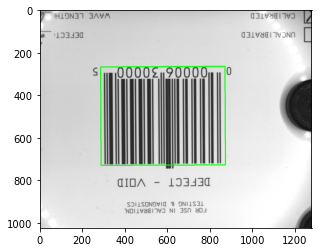

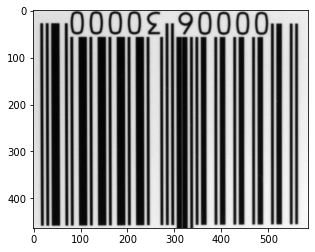

In [48]:
bound_box(f'../images/{images_paths[41]}')

[[283. 263.]
 [868. 263.]
 [283. 725.]
 [868. 725.]]


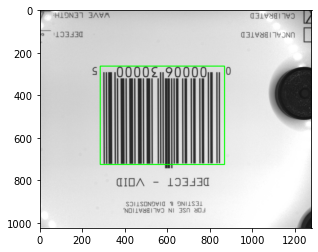

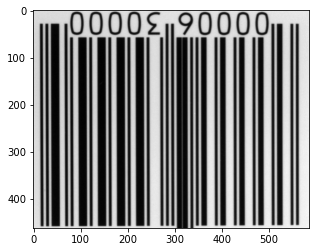

In [49]:
bound_box(f'../images/{images_paths[42]}')

[[277. 259.]
 [862. 260.]
 [277. 721.]
 [862. 721.]]


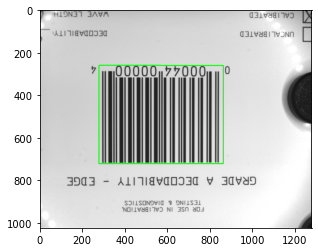

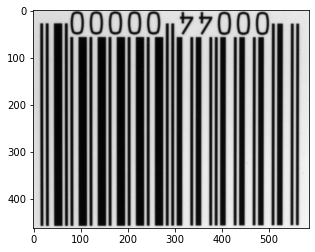

In [50]:
bound_box(f'../images/{images_paths[43]}')

[[277. 259.]
 [862. 260.]
 [277. 721.]
 [862. 721.]]


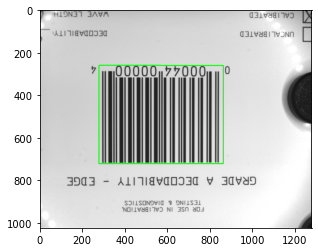

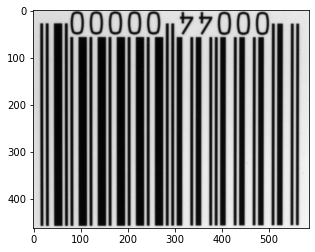

In [51]:
bound_box(f'../images/{images_paths[43]}')

[[288. 264.]
 [873. 269.]
 [285. 728.]
 [870. 732.]]


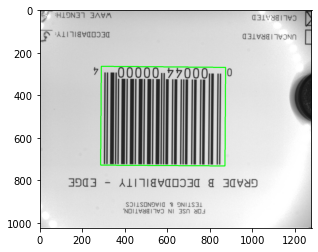

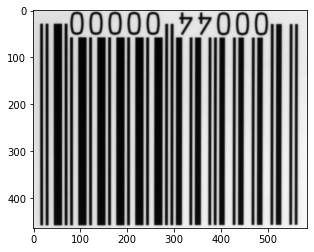

In [52]:
bound_box(f'../images/{images_paths[44]}')

[[276. 278.]
 [862. 278.]
 [276. 741.]
 [862. 741.]]


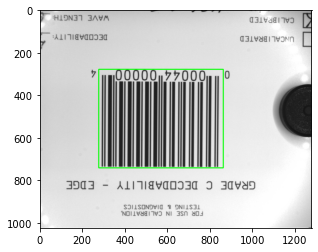

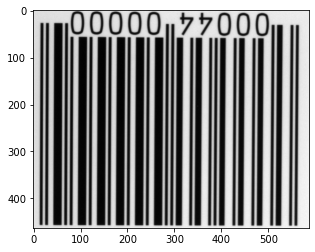

In [53]:
bound_box(f'../images/{images_paths[45]}')

[[261. 266.]
 [847. 273.]
 [255. 729.]
 [841. 737.]]


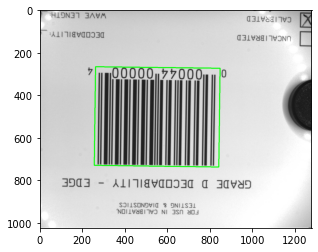

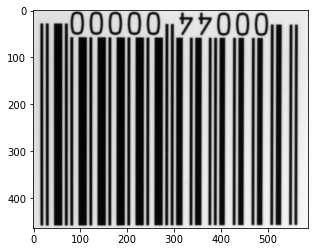

In [54]:
bound_box(f'../images/{images_paths[46]}')

[[256. 273.]
 [842. 280.]
 [251. 737.]
 [837. 743.]]


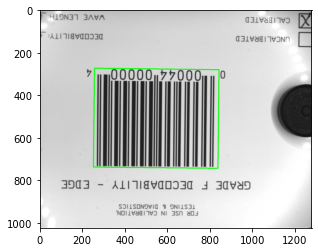

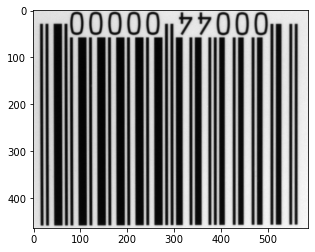

In [55]:
bound_box(f'../images/{images_paths[47]}')

[[250. 272.]
 [836. 280.]
 [244. 736.]
 [830. 743.]]


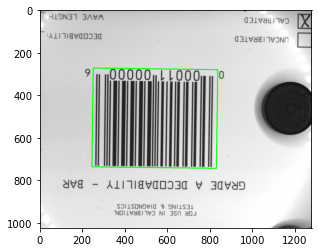

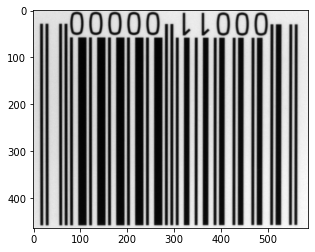

In [56]:
bound_box(f'../images/{images_paths[48]}')

[[254. 273.]
 [840. 280.]
 [248. 737.]
 [834. 744.]]


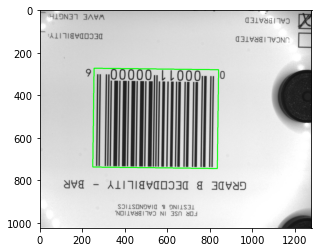

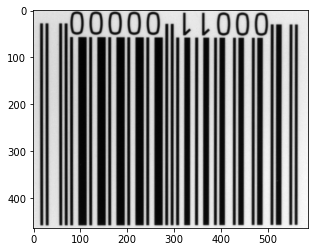

In [57]:
bound_box(f'../images/{images_paths[49]}')

[[278. 251.]
 [864. 259.]
 [272. 714.]
 [858. 721.]]


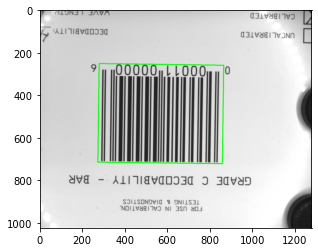

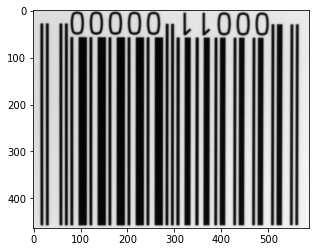

In [58]:
bound_box(f'../images/{images_paths[50]}')

[[280. 260.]
 [866. 268.]
 [274. 724.]
 [860. 732.]]


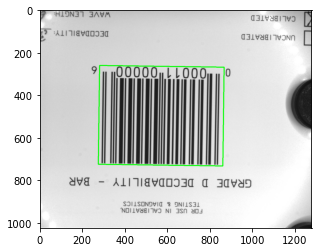

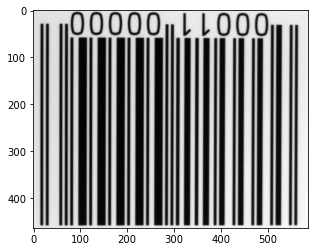

In [59]:
bound_box(f'../images/{images_paths[51]}')

[[294. 263.]
 [879. 265.]
 [292. 726.]
 [877. 728.]]


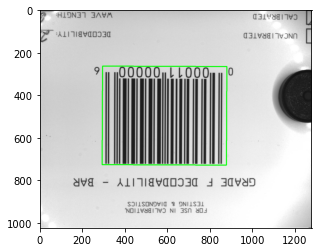

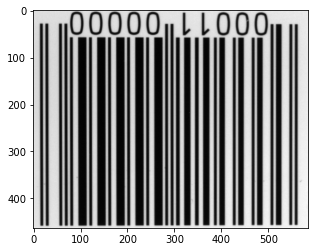

In [60]:
bound_box(f'../images/{images_paths[52]}')

[[ 95.  40.]
 [261.  40.]
 [ 95. 153.]
 [261. 153.]]
Wall time: 33.3 ms


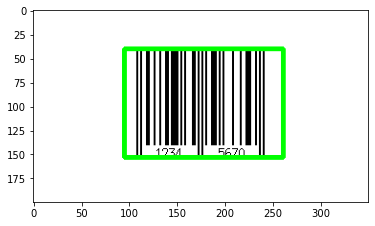

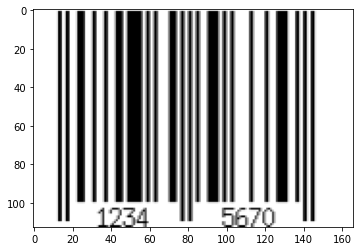

In [61]:
%%time
bound_box('other images/1.png')

[[ 609.  432.]
 [1070.  445.]
 [ 599.  790.]
 [1060.  803.]]
Wall time: 97.4 ms


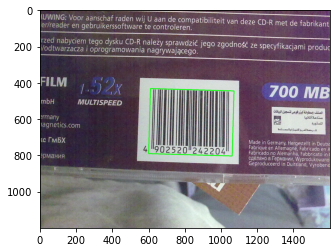

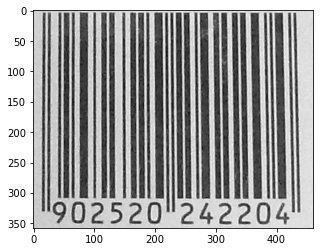

In [62]:
%%time
bound_box('other images/2.jpg')

[[   0.    0.]
 [1198.    0.]
 [   0. 1421.]
 [1198. 1421.]]
Wall time: 180 ms


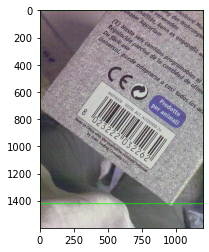

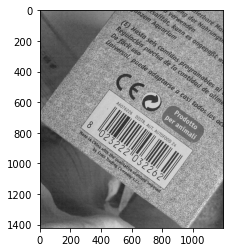

In [63]:
%%time
bound_box('other images/3.jpg')  # NO ROTATION INVARIANCE